In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from scipy.ndimage import convolve
from sklearn import linear_model, svm, datasets, metrics
from sklearn.neural_network import BernoulliRBM
from sklearn.model_selection import train_test_split


In [27]:

def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[1, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode='constant', weights=w).ravel()

    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y


In [28]:
digits = datasets.load_digits()
X = np.asarray(digits.data, 'float32')
X, Y = nudge_dataset(X, digits.target)
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)

In [30]:
"""
Restricted Boltzmann machine as feature encoder for logistic regression
"""
logistic = linear_model.LogisticRegression(solver='newton-cg', tol=1,
                                           multi_class='multinomial')
rbm = BernoulliRBM(random_state=0, verbose=True)

In [31]:
rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

In [47]:
rbm.learning_rate = 0.06
rbm.n_iter = 40
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000


In [48]:
# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, Y_train)


[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.46, time = 0.20s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -24.20, time = 0.28s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -23.09, time = 0.26s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -22.01, time = 0.29s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.59, time = 0.30s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -21.19, time = 0.27s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.72, time = 0.27s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.58, time = 0.27s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.66, time = 0.27s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.19, time = 0.26s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -20.03, time = 0.28s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -19.94, time = 0.26s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -19.77, time = 0.32s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -19.70, time = 0.29s
[BernoulliRBM] Iteration 15, 

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=1, verbose=0, warm_start=False)

In [49]:
Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))


Logistic regression using RBM features:
             precision    recall  f1-score   support

          0       0.99      0.98      0.99       174
          1       0.91      0.92      0.92       184
          2       0.92      0.96      0.94       166
          3       0.92      0.84      0.88       194
          4       0.95      0.97      0.96       186
          5       0.91      0.93      0.92       181
          6       0.98      0.98      0.98       207
          7       0.97      0.96      0.97       154
          8       0.84      0.90      0.87       182
          9       0.88      0.85      0.86       169

avg / total       0.93      0.93      0.93      1797


Logistic regression using raw pixel features:
             precision    recall  f1-score   support

          0       0.91      0.94      0.92       174
          1       0.69      0.74      0.72       184
          2       0.83      0.88      0.86       166
          3       0.81      0.78      0.80       194
        

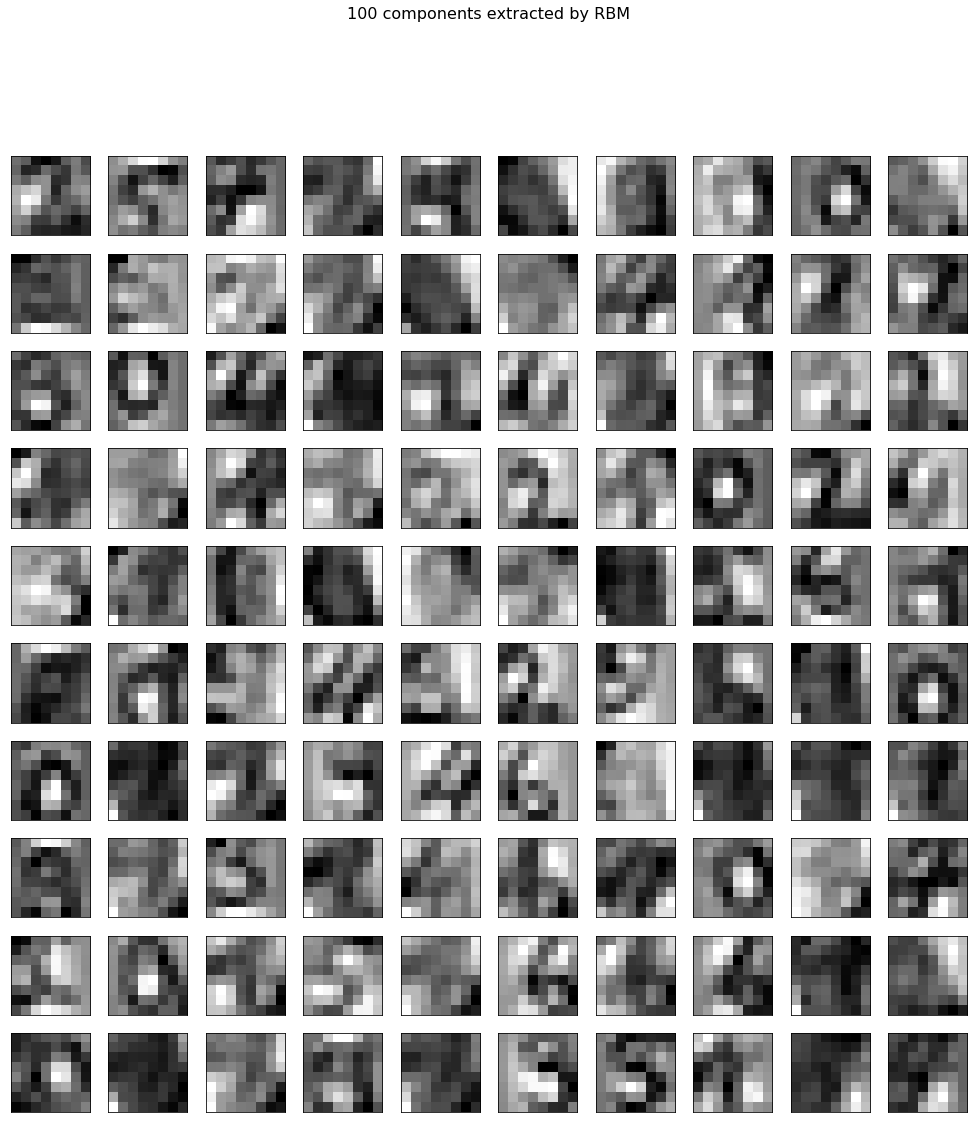

In [50]:
plt.figure(figsize=(16, 16))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10,10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()


In [51]:
from sklearn.svm import LinearSVC
lsvm = LinearSVC()

In [52]:
rbm_features_lsvm_classifier = Pipeline(
    steps=[('rbm', rbm), ('lsvm', lsvm)])

In [53]:
rbm_features_lsvm_classifier.fit(X_train, Y_train)

Y_pred = rbm_features_lsvm_classifier.predict(X_test)
print("linear SVM using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))
lsvm.fit(X_train, Y_train)
Y_pred = lsvm.predict(X_test)

print("linear SVM:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.46, time = 0.19s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -24.20, time = 0.33s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -23.09, time = 0.30s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -22.01, time = 0.31s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.59, time = 0.27s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -21.19, time = 0.30s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.72, time = 0.33s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.58, time = 0.33s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.66, time = 0.28s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.19, time = 0.29s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -20.03, time = 0.28s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -19.94, time = 0.34s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -19.77, time = 0.28s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -19.70, time = 0.26s
[BernoulliRBM] Iteration 15, 

In [176]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20, 8), random_state=1)
rbm_features_mlp_classifier = Pipeline(
    steps=[('rbm', rbm), ('mlp', mlp)])

In [177]:
rbm_features_mlp_classifier.fit(X_train, Y_train)

Y_pred = rbm_features_mlp_classifier.predict(X_test)
print("MLP using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))
mlp.fit(X_train, Y_train)

Y_pred = mlp.predict(X_test)
print("MLP:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.46, time = 0.21s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -24.20, time = 0.27s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -23.09, time = 0.26s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -22.01, time = 0.26s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.59, time = 0.26s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -21.19, time = 0.28s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.72, time = 0.26s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.58, time = 0.30s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.66, time = 0.26s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.19, time = 0.27s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -20.03, time = 0.26s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -19.94, time = 0.28s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -19.77, time = 0.25s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -19.70, time = 0.26s
[BernoulliRBM] Iteration 15, 

In [182]:
"Principal Component Analysis for Dimensionality Reduction"
from sklearn.decomposition import PCA
pca = PCA(n_components=24)
pca_features_mlp_classifier = Pipeline(
    steps=[('pca', pca), ('mlp', mlp)])

In [183]:
pca_features_mlp_classifier.fit(X_train, Y_train)

Y_pred = pca_features_mlp_classifier.predict(X_test)
print("MLP using PCA features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))
mlp.fit(X_train, Y_train)

Y_pred = mlp.predict(X_test)
print("MLP:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

MLP using PCA features:
             precision    recall  f1-score   support

          0       0.97      0.96      0.96       174
          1       0.92      0.93      0.92       184
          2       0.94      0.93      0.94       166
          3       0.93      0.90      0.91       194
          4       0.93      0.92      0.92       186
          5       0.92      0.91      0.92       181
          6       0.98      0.97      0.97       207
          7       0.92      0.97      0.95       154
          8       0.86      0.89      0.88       182
          9       0.90      0.88      0.89       169

avg / total       0.93      0.93      0.93      1797


MLP:
             precision    recall  f1-score   support

          0       0.95      0.97      0.96       174
          1       0.80      0.78      0.79       184
          2       0.85      0.93      0.89       166
          3       0.86      0.84      0.85       194
          4       0.95      0.90      0.92       186
          5 

In [137]:
from sklearn.feature_selection import SelectKBest
kbest=SelectKBest( k=32)
kbest_features_logistic_classifier = Pipeline(
    steps=[('kbest', kbest), ('logistic', logistic)])

In [138]:
kbest_features_logistic_classifier.fit(X_train, Y_train)

Y_pred = kbest_features_logistic_classifier.predict(X_test)
print("Logistic Regression using KBest features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))
logistic.fit(X_train, Y_train)
Y_pred = logistic.predict(X_test)
print("Logistic Regression:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Logistic Regression using KBest features:
             precision    recall  f1-score   support

          0       0.74      0.86      0.79       174
          1       0.56      0.56      0.56       184
          2       0.76      0.83      0.79       166
          3       0.72      0.73      0.72       194
          4       0.75      0.70      0.72       186
          5       0.71      0.74      0.72       181
          6       0.89      0.82      0.85       207
          7       0.70      0.84      0.76       154
          8       0.69      0.52      0.59       182
          9       0.64      0.61      0.62       169

avg / total       0.72      0.72      0.72      1797


Logistic Regression:
             precision    recall  f1-score   support

          0       0.91      0.94      0.93       174
          1       0.69      0.73      0.71       184
          2       0.82      0.87      0.85       166
          3       0.81      0.77      0.79       194
          4       0.84      0.8

In [167]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
selector = RFE(rf, 10)
selector = selector.fit(X_train, Y_train)
Y_pred=selector.predict(X_test)
print("rf using RFE features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))
rf.fit(X_train, Y_train)
Y_pred=rf.predict(X_test)
print("native rf:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

rf using RFE features:
             precision    recall  f1-score   support

          0       0.92      0.91      0.91       174
          1       0.84      0.83      0.83       184
          2       0.84      0.92      0.88       166
          3       0.78      0.77      0.77       194
          4       0.86      0.80      0.82       186
          5       0.69      0.65      0.67       181
          6       0.87      0.84      0.85       207
          7       0.82      0.94      0.87       154
          8       0.71      0.68      0.69       182
          9       0.68      0.72      0.70       169

avg / total       0.80      0.80      0.80      1797


native rf:
             precision    recall  f1-score   support

          0       0.98      0.98      0.98       174
          1       0.93      0.98      0.96       184
          2       0.98      0.99      0.99       166
          3       0.96      0.89      0.93       194
          4       0.98      0.97      0.98       186
       

In [171]:
from sklearn.feature_selection import RFE
selector = RFE(lsvm, 200) 
selector = selector.fit(X_train, Y_train)
Y_pred=selector.predict(X_test)
print("rf using RFE features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))
rf.fit(X_train, Y_train)
Y_pred=lsvm.predict(X_test)
print("native rf:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

rf using RFE features:
             precision    recall  f1-score   support

          0       0.84      0.94      0.89       174
          1       0.66      0.70      0.68       184
          2       0.76      0.88      0.82       166
          3       0.80      0.75      0.77       194
          4       0.88      0.80      0.84       186
          5       0.75      0.83      0.79       181
          6       0.94      0.90      0.92       207
          7       0.83      0.90      0.86       154
          8       0.77      0.58      0.66       182
          9       0.73      0.70      0.72       169

avg / total       0.80      0.80      0.80      1797


native rf:
             precision    recall  f1-score   support

          0       0.84      0.94      0.89       174
          1       0.66      0.70      0.68       184
          2       0.76      0.88      0.82       166
          3       0.80      0.75      0.77       194
          4       0.88      0.80      0.84       186
       